# Predicting Heart Failure: A Potential Life-Saving Model
Names: Kenneth Samaniego and Sophia Nguyen

## Intro
We will ba analyzing a dataset on heart failure to potentially predict the chances of someone at risk of heart failures, and this will be accomplished by using a variety of models to test whiich would be the most accurate to accomplish this.

## Imports
Here we are taking our dataset and importing the necessary libraries that are crucial for the first step and analyzing the data, the preproccessing.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample

# TEST TO LOAD DATASET
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Part 1: Data Preprocessing
1. Exporatory Data Analysis (EDA): This displays genereal dataset information and summary statistics. We also visualized class distributions of the target variables to assess class balance. Histograms for key numerical features, such as `Age`, `RestingBP`, and `Cholestorol`, to observer their distributions. We also used a correlation heatmap to identify the linear realtionships between different numeric features.
2. Missing Values and Outliers: We replaced invalid zero values that were in in `Cholesterol` and `RestingBP` with`NaN`. Treated the outliers in numerical features using the interquartile range(IQR) method. 
3. Encoding: Binary features were mapped to `0` and `1`, such as sex and exercise angina.
4. Normalization: Standardized the numerical features using `StandardScaler` to ensure that all features have zero mean and unit variance, so that model performance can improve.
5. Train-Test Split: Split the data into training and testing sets with an 80-20 ration. This was done using stratification to preserve the class balance in both of the sets.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


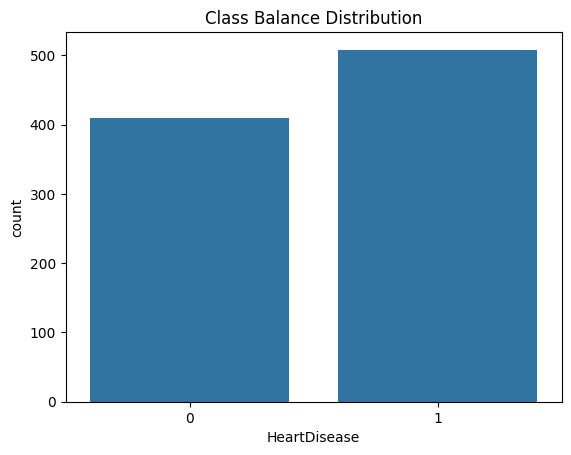

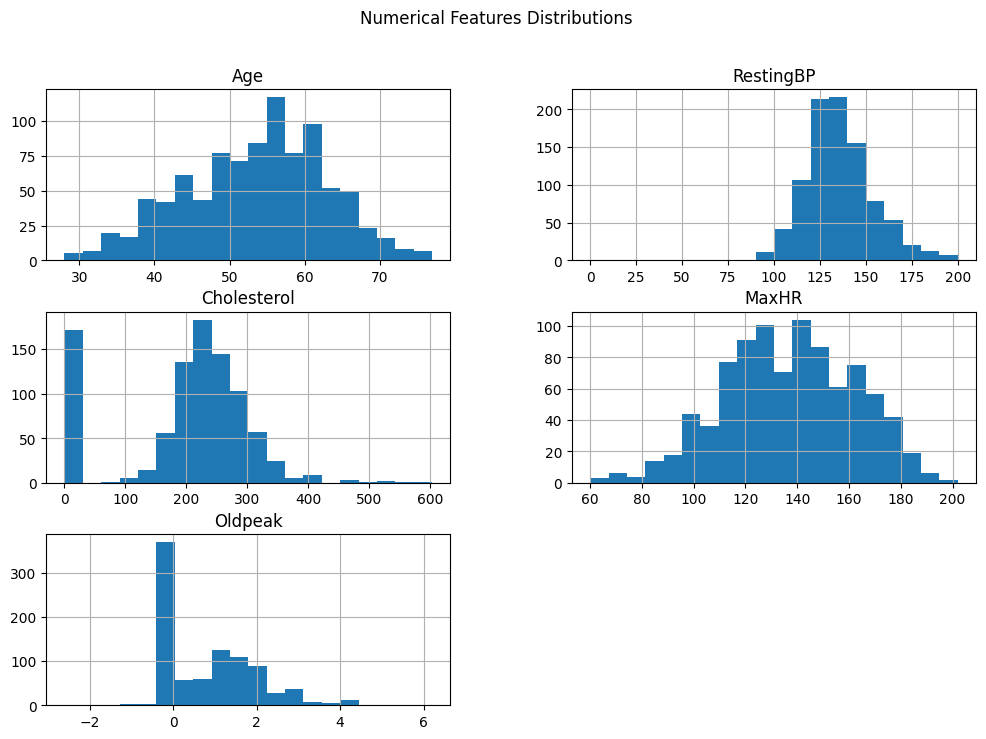

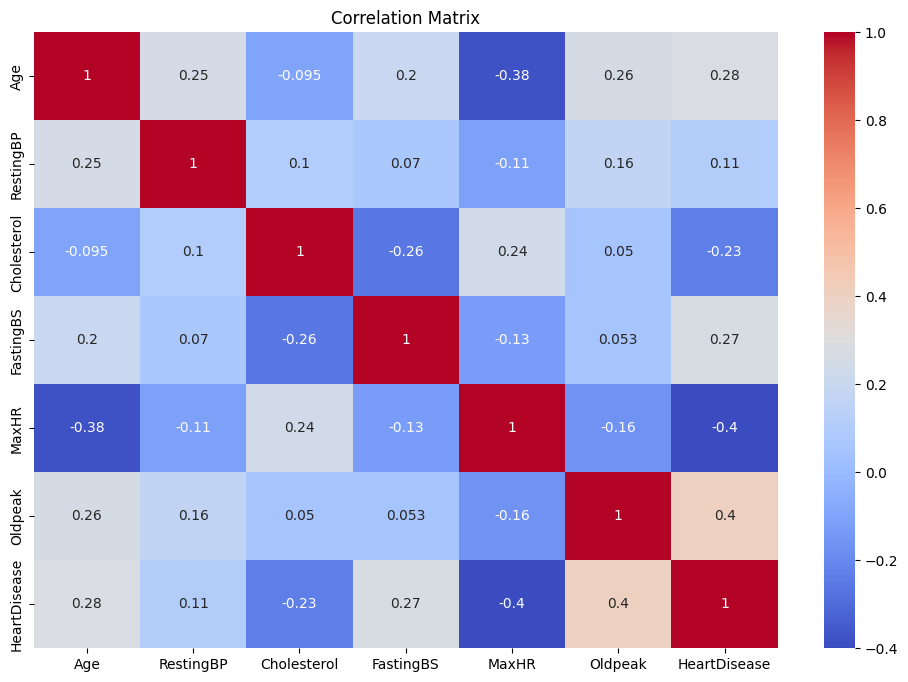

Missing values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Class distribution before splitting: HeartDisease
1    508
0    410
Name: count, dtype: int64
Train class distribution: HeartDisease
1    406
0    328
Name: count, dtype: int64


In [2]:
# EDA =================================
df.info() #general info
df.describe(include='all') # stats

#checking for class balance
sns.countplot(x='HeartDisease', data=df)
plt.title('Class Balance Distribution')
plt.show()

# Distributions for numerical features (age, restingbp, cholestrerol, etc.)
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[features].hist(figsize=(12,8), bins=20)
plt.suptitle('Numerical Features Distributions')
plt.show()

#correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Missing vals & outliers =================================
print('Missing values:')
print(df.isnull().sum()) # check for missing values (aka NULL)

#handle missing/zeroes in Cholesterol & Resting BP values since those physically can't be 0
for i in ['Cholesterol', 'RestingBP']:
    df[i] = df[i].replace(0, np.nan) #replaces 0's w/ NaN's
    df[i] = df[i].fillna(df[i].median())

#handle outliers (w/ IQR)
for i in features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3- Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[i] = np.where(df[i] < lower, lower, np.where(df[i] > upper, upper, df[i]))

# Encode categorical variables =================================
df['Sex'] = df['Sex'].map({'M':1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# multiclass categorical variable
df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

# Normalize =================================
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Training set & testing set =================================
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print(f'Class distribution before splitting: {y.value_counts()}') # FOR CHECKING CLASS BALANCE

#the actual splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f'Train class distribution: {y_train.value_counts()}') #CHECK BALANCE AFTER SPLIT

## Part 1 Continued: Handling Class Imbalance
1. Class Distribution Check: We verified class prpotions in the training set to assess how bad the imbalance is in the dataset.
2. Upsampling Minority Class: Combined `X_train` and `y_train` so that it is in a single DataFrame. Seperated the dataset into majority and minority classes, which were `HeartDisease = 1` and `HeartDisease = 0`. Random upsampling of the minority class to match the size of the majority class and this was done using `resample()` and `sklearn.utils`.
3. Post-Processing: Split the rebalanced dataset back into `X_train_balanced` and `y_train_balanced` and then verified the new class distribution to ensure it was balanced.

In [3]:
# Check imbalance =================================
temp = pd.concat([X_train, y_train], axis=1)

print(f"Checking imbalance: {temp['HeartDisease'].value_counts()}")
# outputs:
    #Class 1 (Heart Disease): 406 (~55.3%)
    #CLass 0 (No Disease) : 328 (~44.7)
# Means it's a mild class imbalance

# tackling data imbalance =====
train_df = pd.concat([X_train, y_train], axis=1) #combine X_train & y_train to resample

#separate major & minor classes
majority = train_df[train_df.HeartDisease == 1]
minority = train_df[train_df.HeartDisease == 0]

#upsample minority
minority_upsample = resample(minority, replace=True, n_samples=len(majority), random_state=42)

train_balanced = pd.concat([majority, minority_upsample]) #combine back
#shuffle & split
X_train_balanced = train_balanced.drop('HeartDisease', axis=1)
y_train_balanced = train_balanced['HeartDisease']

#check new class balance
print(f'Balanced training set: {y_train_balanced.value_counts()}')

Checking imbalance: HeartDisease
1    406
0    328
Name: count, dtype: int64
Balanced training set: HeartDisease
1    406
0    406
Name: count, dtype: int64


## Part 2: Model Design and Training
We designed and trained a set of classification models to be able to evaluate their perfornamce on our main task, prediction of heart diseases. Machine learning algorithms we used are:
* Logistic Regression
* Decision Tree
* Naive Bayes
* Support Vector Machine (SVM)
* Multi-Layer Perceptron (Neural Network)
* Random Forest
* Adaboost

Each model is trained on the balanced training dataset and then it is evaluated on the test dataset. We using the following performance metric to measure the models:
* Accuracy
* Precision
* Recall
* F1 Score
* ROC AUC Score
* Inference Time

After Training: Displayed confusion matrics using heatmaps to give a visual comparison of the predictions. The classification reports and ROC AUC score are printed to give more insight on the details. The metrics were stored in a summary list and then converted to a Data Frame. The summary table is sorted by F1 Score to be able to identify the best-performing mode.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine (SVM)": SVC(probability=True),  # set probability=True to use predict_proba
    "MLP (Neural Network) ": MLPClassifier(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

def train_model(X_train, y_train, X_test, y_test, models, clock=False, return_summary=False):
    '''Returns a list of [dict, dict, list]: [results, times, summary]
       if clock = True, then will show times
       if return_summary = True, then will collect metrics summary'''
    
    results = {}
    times = {}
    summary = []
    
    for name, model in models.items():
        if clock:
            start_time = time.time()
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        elapsed_time = time.time() - start_time if clock else None
        if clock:
            times[name] = {'Time elapsed': round(elapsed_time, 4)}
        
        if return_summary:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc = roc_auc_score(y_test, y_proba)

            summary.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC AUC': roc,
                'Inference Time (s)': round(elapsed_time, 4) if clock else None
            })

        print(f"\n{name} Results:")
        cmatrix = (confusion_matrix(y_test, y_pred))
        plt.figure(figsize=(3, 2))
        sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Greens')
        plt.title(f'{name} - Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba)}")
        if clock:
            print(f"Inference Time: {elapsed_time:.4f} seconds")
        
        results[name] = {
            'conf_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }


    return [results, times, summary]


Logistic Regression Results:


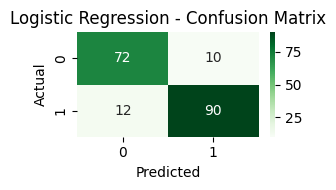

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        82
           1       0.90      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

ROC AUC Score: 0.9231229076996652
Inference Time: 0.0140 seconds

Decision Tree Results:


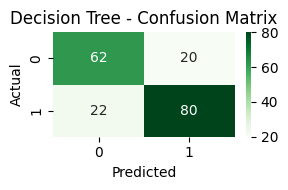

              precision    recall  f1-score   support

           0       0.74      0.76      0.75        82
           1       0.80      0.78      0.79       102

    accuracy                           0.77       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.77      0.77      0.77       184

ROC AUC Score: 0.770205643232903
Inference Time: 0.0030 seconds

Naive Bayes Results:


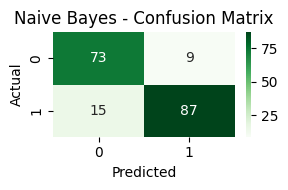

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        82
           1       0.91      0.85      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

ROC AUC Score: 0.9408177905308465
Inference Time: 0.0020 seconds

Support Vector Machine (SVM) Results:


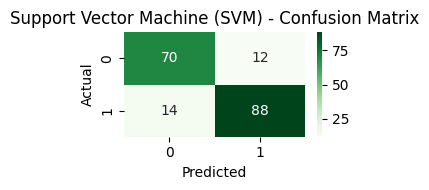

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        82
           1       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC AUC Score: 0.9240793878527022
Inference Time: 0.0521 seconds

MLP (Neural Network)  Results:


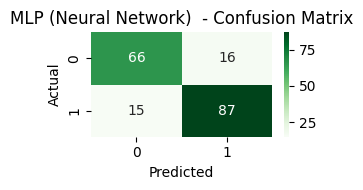

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        82
           1       0.84      0.85      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184

ROC AUC Score: 0.9067431850789096
Inference Time: 1.0404 seconds

Random Forest Results:


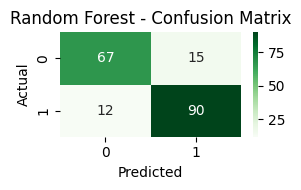

              precision    recall  f1-score   support

           0       0.85      0.82      0.83        82
           1       0.86      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

ROC AUC Score: 0.9195361071257772
Inference Time: 0.0790 seconds

AdaBoost Results:


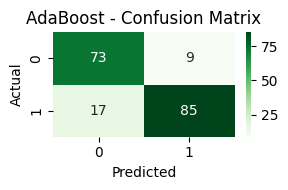

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        82
           1       0.90      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC AUC Score: 0.911166905786705
Inference Time: 0.0470 seconds

=== Summary Metrics ===
                          Model  Accuracy  Precision    Recall  F1 Score  \
0           Logistic Regression  0.880435   0.900000  0.882353  0.891089   
2                   Naive Bayes  0.869565   0.906250  0.852941  0.878788   
3  Support Vector Machine (SVM)  0.858696   0.880000  0.862745  0.871287   
5                 Random Forest  0.853261   0.857143  0.882353  0.869565   
6                      AdaBoost  0.858696   0.904255  0.833333  0.867347   
4         MLP (Neural Network)   0.831522   0.844660  0.852941  0.848780   
1                 Decision Tree  0.771739   0.800000

In [5]:
results, times, summary = train_model(X_train_balanced, y_train_balanced, X_test, y_test, models, clock=True, return_summary=True)

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary)
# Sort and visualize
summary_df = summary_df.sort_values(by= 'F1 Score' , ascending=False)

print('\n=== Summary Metrics ===')
print(summary_df)

## Part 3: Model Improvements


To boost performance and reduce overfitting, we applied **GridSearchCV** to fine-tune hyperparameters for several classification models. This approach uses 5-fold cross-validation to evaluate different parameter combinations and select the best-performing setup for each model.

- **Decision Tree**  
  Tuned parameters: `max_depth`, `criterion`, `min_samples_split`, `min_samples_leaf`  
  Helps control tree complexity and improve generalization.

- **Support Vector Machine (SVM)**  
  Tuned parameters: `C`, `kernel`, and `gamma`  
  →These affect how the decision boundary is shaped and how well the model balances bias and variance.

- **Logistic Regression**  
  Tuned parameters: `C`, `penalty`, and `solver`  
  Mainly focused on regularization to avoid overfitting while keeping the model interpretable.

- **MLP (Neural Network)**  
  Tuned parameters: `hidden_layer_sizes`, `activation`, `alpha`, `solver`, and `learning_rate`  
  These were chosen to help the network learn efficiently and avoid underfitting or overfitting.

- **Naive Bayes**  
  Tuned parameter: `var_smoothing`  
  Helps with numerical stability and can slightly improve predictions.

- **Random Forest**  
  Tuned parameters: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `criterion`  
  These control the diversity and depth of the trees, which can improve overall accuracy and reduce overfitting.

Each model was retrained with the best-found parameters and will be used in the final evaluation and comparison.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score

# Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, n_jobs=-1)
grid_dt.fit(X_train_balanced, y_train_balanced)
print("Best Decision Tree Params:", grid_dt.best_params_)

# SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1)
grid_svm.fit(X_train_balanced, y_train_balanced)
print("Best SVM Params:", grid_svm.best_params_)

# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Supports both l1 and l2
}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, n_jobs=-1)
grid_lr.fit(X_train_balanced, y_train_balanced)
print("Best Logistic Regression Params:", grid_lr.best_params_)


# MLP Classifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive']
}
grid_mlp = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True), param_grid_mlp, cv=5, n_jobs=-1)
grid_mlp.fit(X_train_balanced, y_train_balanced)
print("Best MLP Parameters:", grid_mlp.best_params_)

# Naive Bayes
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train_balanced, y_train_balanced)
print("Best Naive Bayes Parameters:", grid_nb.best_params_)

#random forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [5, 10, 20, None],            # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples at each leaf
    'criterion': ['gini', 'entropy']           # Function to measure the quality of a split
}

grid_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_balanced, y_train_balanced)
print("Best Random Forest Paramaters:", grid_rf.best_params_)



Best Decision Tree Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best SVM Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Logistic Regression Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best MLP Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Naive Bayes Parameters: {'var_smoothing': 1e-09}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest Paramaters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}



Decision Tree (Improved) Results:


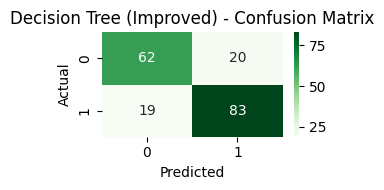

              precision    recall  f1-score   support

           0       0.77      0.76      0.76        82
           1       0.81      0.81      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.78      0.79       184
weighted avg       0.79      0.79      0.79       184

ROC AUC Score: 0.7735533237685317
Inference Time: 0.0040 seconds

SVM (Improved) Results:


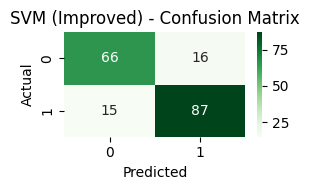

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        82
           1       0.84      0.85      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184

ROC AUC Score: 0.9056671449067432
Inference Time: 0.0480 seconds

Logistic Regression (Improved) Results:


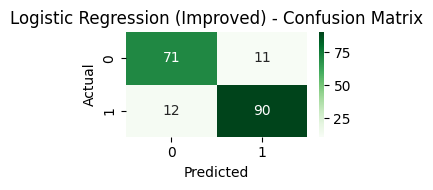

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        82
           1       0.89      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184

ROC AUC Score: 0.9218077474892394
Inference Time: 0.0030 seconds

MLP (Improved) Results:


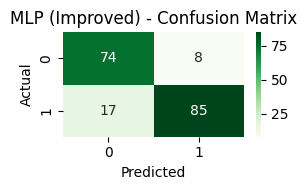

              precision    recall  f1-score   support

           0       0.81      0.90      0.86        82
           1       0.91      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184

ROC AUC Score: 0.9308943089430894
Inference Time: 0.1000 seconds

Naive Bayes (Improved) Results:


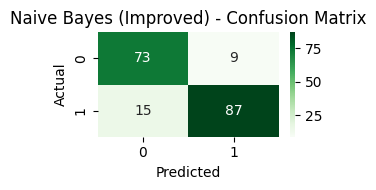

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        82
           1       0.91      0.85      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

ROC AUC Score: 0.9408177905308465
Inference Time: 0.0020 seconds

Random Forest (Improved) Results:


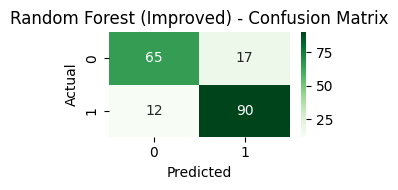

              precision    recall  f1-score   support

           0       0.84      0.79      0.82        82
           1       0.84      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

ROC AUC Score: 0.9169057867049257
Inference Time: 0.1590 seconds

=== Tuned Model Summary Matrix ===
                            Model  Accuracy  Precision    Recall  F1 Score  \
2  Logistic Regression (Improved)  0.875000   0.891089  0.882353  0.886700   
4          Naive Bayes (Improved)  0.869565   0.906250  0.852941  0.878788   
3                  MLP (Improved)  0.864130   0.913978  0.833333  0.871795   
5        Random Forest (Improved)  0.842391   0.841121  0.882353  0.861244   
1                  SVM (Improved)  0.831522   0.844660  0.852941  0.848780   
0        Decision Tree (Improved)  0.788043   0.805825  0.813725  0.809756   

    ROC AUC  Inference Ti

In [9]:
models_tuned = {
    'Decision Tree (Improved)': grid_dt.best_estimator_,
    'SVM (Improved)': grid_svm.best_estimator_,
    'Logistic Regression (Improved)': grid_lr.best_estimator_,
    'MLP (Improved)': grid_mlp.best_estimator_,
    'Naive Bayes (Improved)': grid_nb.best_estimator_,
    'Random Forest (Improved)': grid_rf.best_estimator_,
}

results_tuned, times_tuned, summary_tuned = train_model( 
    X_train_balanced, y_train_balanced, X_test, y_test, models = models_tuned,clock=True,return_summary=True,)


# Convert summary to DataFrame for tuned models
summary_tuned_df = pd.DataFrame(summary_tuned)

# Sort by 'F1 Score' (or any other metric you'd like) for tuned models
summary_tuned_df_sorted = summary_tuned_df.sort_values(by='F1 Score', ascending=False)

print('\n=== Tuned Model Summary Matrix ===')
print(summary_tuned_df_sorted)


## Part 4: Model Comparison and Interpretation


=== Original Model Summary Matrix ===
                          Model  Accuracy  Precision    Recall  F1 Score  \
0           Logistic Regression  0.880435   0.900000  0.882353  0.891089   
2                   Naive Bayes  0.869565   0.906250  0.852941  0.878788   
3  Support Vector Machine (SVM)  0.858696   0.880000  0.862745  0.871287   
5                 Random Forest  0.853261   0.857143  0.882353  0.869565   
6                      AdaBoost  0.858696   0.904255  0.833333  0.867347   
4         MLP (Neural Network)   0.831522   0.844660  0.852941  0.848780   
1                 Decision Tree  0.771739   0.800000  0.784314  0.792079   

    ROC AUC  Inference Time (s)  
0  0.923123              0.0140  
2  0.940818              0.0020  
3  0.924079              0.0521  
5  0.919536              0.0790  
6  0.911167              0.0470  
4  0.906743              1.0404  
1  0.770206              0.0030  

=== Tuned Model Summary Matrix ===
                            Model  Accuracy 

C:\Users\Kenneth Samaniego\AppData\Local\Temp\ipykernel_81324\1060264351.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Model', data=summary_df_sorted, palette='crest')


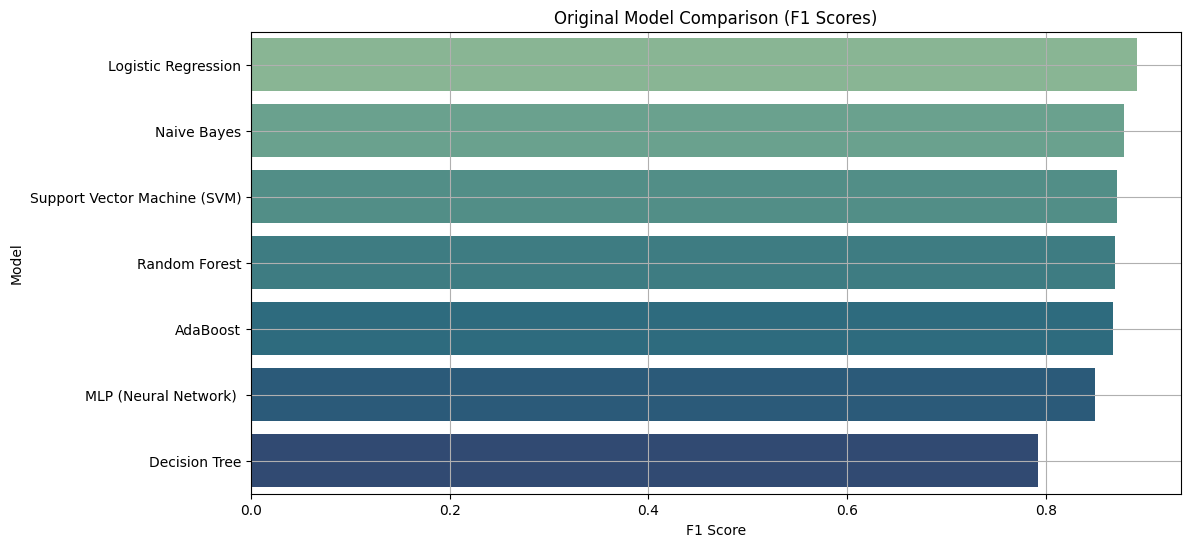

C:\Users\Kenneth Samaniego\AppData\Local\Temp\ipykernel_81324\1060264351.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Model', data=summary_tuned_df_sorted, palette='crest')


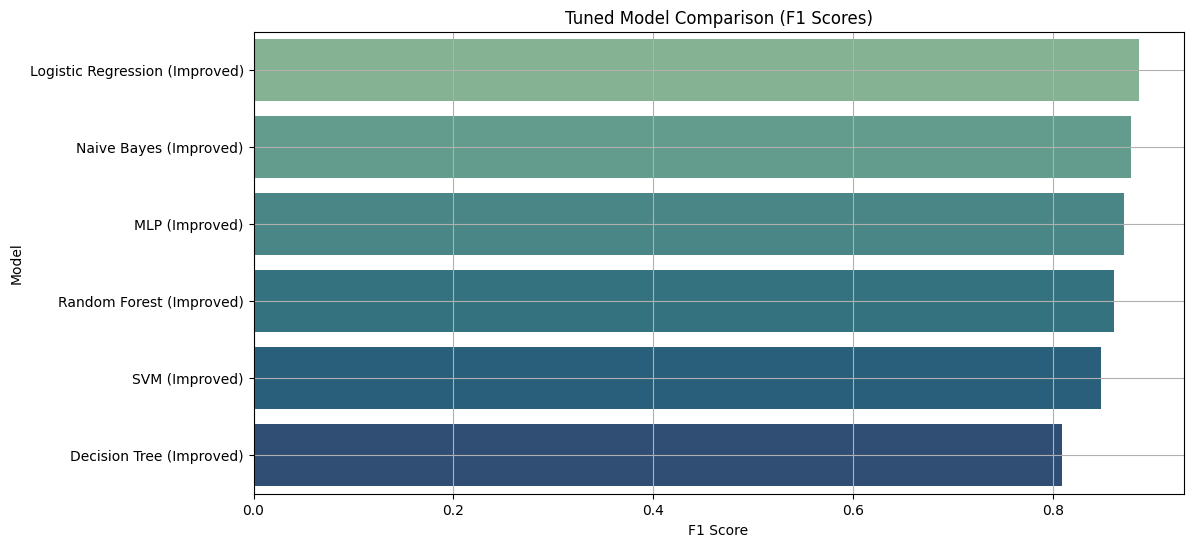

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Convert summary to DataFrame for original models
summary_df = pd.DataFrame(summary)

# Convert summary to DataFrame for tuned models
summary_tuned_df = pd.DataFrame(summary_tuned)

# Sort by 'F1 Score' (or any other metric you'd like) for original models
summary_df_sorted = summary_df.sort_values(by='F1 Score', ascending=False)

# Sort by 'F1 Score' (or any other metric you'd like) for tuned models
summary_tuned_df_sorted = summary_tuned_df.sort_values(by='F1 Score', ascending=False)

# Print the summary matrices for both original and tuned models
print('\n=== Original Model Summary Matrix ===')
print(summary_df_sorted)

print('\n=== Tuned Model Summary Matrix ===')
print(summary_tuned_df_sorted)

# Plot a bar graph comparing F1 scores for original models
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Model', data=summary_df_sorted, palette='crest')
plt.title('Original Model Comparison (F1 Scores)')
plt.grid(True)
plt.show()

# Plot a bar graph comparing F1 scores for tuned models
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Model', data=summary_tuned_df_sorted, palette='crest')
plt.title('Tuned Model Comparison (F1 Scores)')
plt.grid(True)
plt.show()




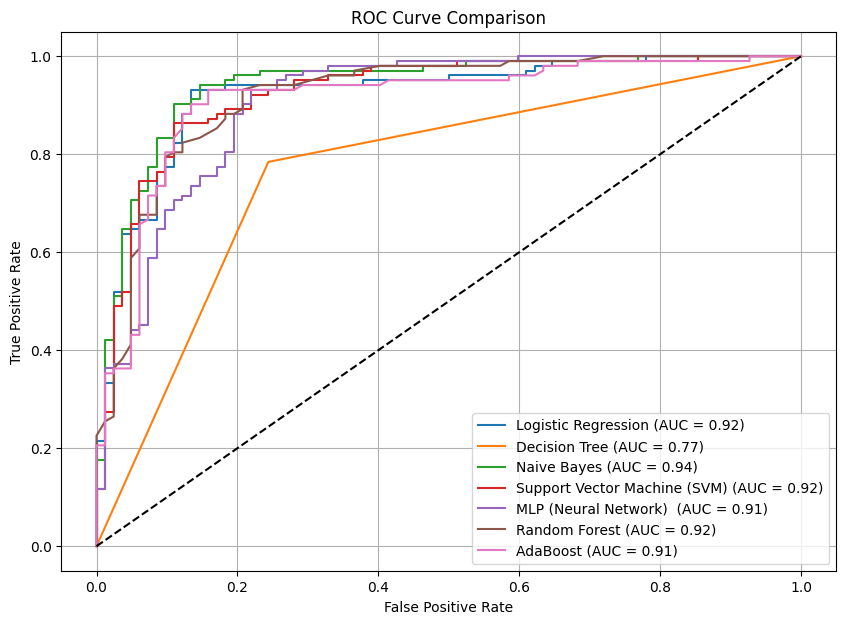

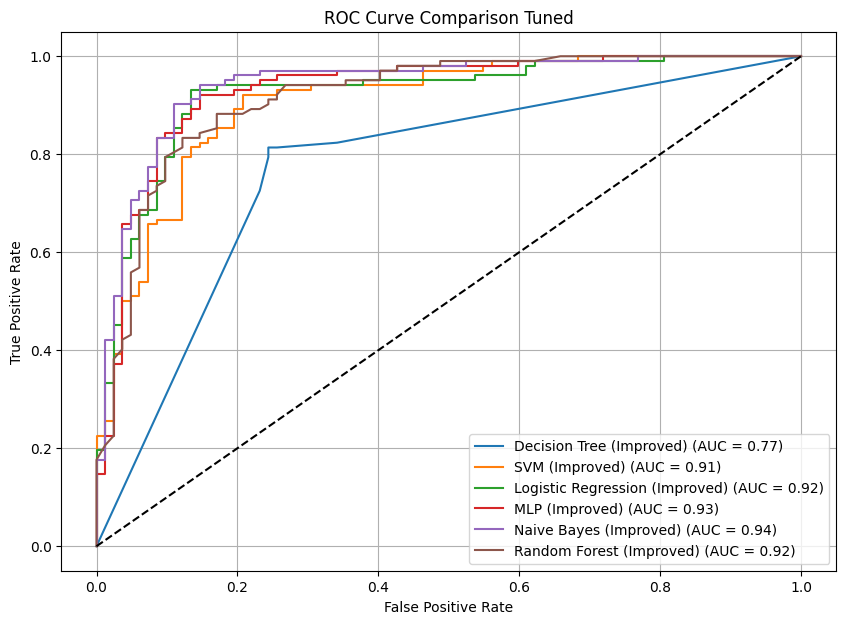

In [11]:
from sklearn.metrics import roc_curve, auc

# ROC Curve Plot
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# ROC Curve Plot for Tuned models
plt.figure(figsize=(10, 7))
for name, model in models_tuned.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Tuned')
plt.legend()
plt.grid()
plt.show()


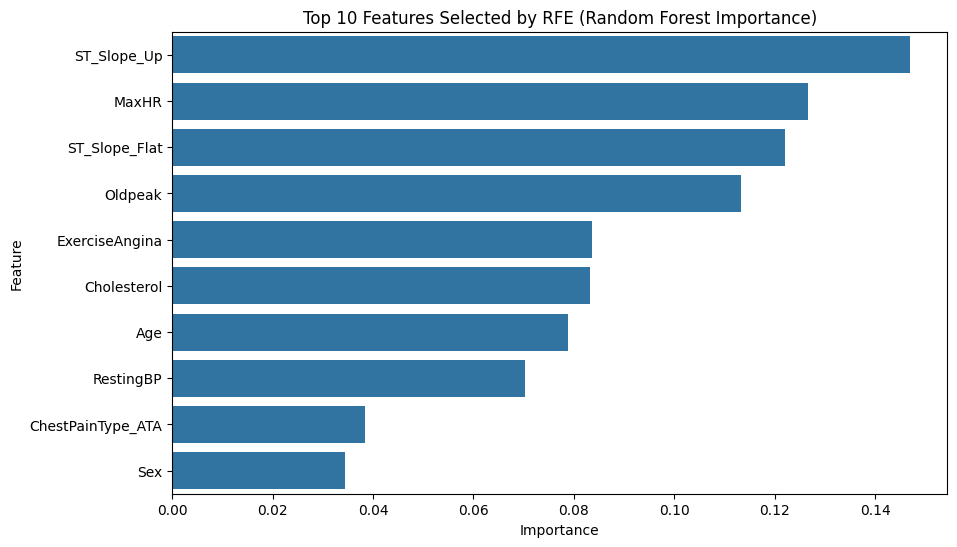

,Feature,Importance,RFE_Selected
14,ST_Slope_Up,0.146999,True
5,MaxHR,0.126615,True
13,ST_Slope_Flat,0.121991,True
7,Oldpeak,0.113307,True
6,ExerciseAngina,0.083653,True
3,Cholesterol,0.083253,True
0,Age,0.078765,True
2,RestingBP,0.070217,True
8,ChestPainType_ATA,0.038320,True
9,ChestPainType_NAP,0.036466,False


In [12]:
# Feature importance from Random Forest
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Fit Random Forest (if not already trained)
rf_model = models['Random Forest']

# Feature importances
importances = rf_model.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})

# RFE with top 10 features
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Add RFE selection status
feat_imp_df['RFE_Selected'] = rfe.support_

# Filter only RFE-selected features for plotting
selected_feat_df = feat_imp_df[feat_imp_df['RFE_Selected']].sort_values(by='Importance', ascending=False)

# Plot feature importances for RFE-selected features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=selected_feat_df)
plt.title('Top 10 Features Selected by RFE (Random Forest Importance)')
plt.show()

# Display full feature importance table with RFE selection status
display(feat_imp_df.sort_values(by='Importance', ascending=False))